In [1]:
import os 
import sys 
import torch
from torch.utils.data import Dataset, DataLoader

import sklearn
import numpy as np
from scipy import signal
# import nn from pytorch 
import matplotlib.pyplot as plt
import torch.nn as nn
# sys import path
sys.path.append(os.path.abspath(os.path.join('..')))
from DataLoaders    import  data_loader
from models.convnet import ConvNet_v1
from train_utils.conv_net_train_utils import run_epoch,evaluate_performance



In [2]:
MAIN_PATH         = os.path.join('..','bert2sage_data',"Data")
ProBertDataset    = data_loader.ProBertEmbeddings(data_path=MAIN_PATH)


### SPLIT DATASET ###
n          = len(ProBertDataset)     # total number of examples
n_test     = int(0.1 * n)       # take ~10% for test
n_val      = int(0.1 * n)      # take ~05% for validation
n_train    = n - n_test - n_val # take the rest for training
batch_size = 1                  # batch size


TrainData,TestData,ValData,= torch.utils.data.random_split(ProBertDataset, [n_train,n_test,n_val])


#### Create a DataLoader for our training set ####
train_loader  = DataLoader(dataset=TrainData, batch_size=batch_size, shuffle=False,num_workers=10)
test_loader   = DataLoader(dataset=TestData,  batch_size=batch_size, shuffle=False,num_workers=10)
val_loader    = DataLoader(dataset=ValData,   batch_size=batch_size, shuffle=False,num_workers=10)


Real_batch = 2**10

### Show Data ###
print(f"Total: {n}")
print(f"Test:  {n_test}")
print(f"Val:   {n_val}")
print(f"Train: {n_train}")



Total: 15
Test:  1
Val:   1
Train: 13


In [3]:
sigmoid   = nn.Sigmoid()
threshold =  0.5
epocs     =  3
learning_rate = 0.00001


model     = ConvNet_v1()
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(100))
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


for epoch in range(1, epocs + 1):
    loss_list_epoch = run_epoch(model               = model ,
                                test_loader         = test_loader ,
                                Real_batch          = Real_batch,
                                loader              = train_loader,
                                optimizer           = optimizer,
                                criterion           = criterion,
                                epoch               = epoch,
                                print_every         = 1)



                                
    accuracy_list_epoch = evaluate_performance(model               = model ,
                                               loader              = val_loader,
                                               activation_function = sigmoid,
                                               threshold           = threshold,
                                               Real_batch          = Real_batch)

Epoch 1 Loss: 0.692126989364624   Accuracy: [0.99316406]


In [25]:
accuracy_list_epoch 

array([0.99902344])

In [5]:
for Z,Y  in  val_loader: 
    break

In [18]:
target_idx      = 4
Z_source        =  Z[:,target_idx,:].unsqueeze(0).permute(1,0,2)
interaction_ids = torch.where(Y[:,target_idx,:]==1)
idx             =  interaction_ids[1][1]
Z_target        = Z[:,idx ,:].unsqueeze(0).permute(1,0,2)
Xb              = torch.cat((Z_source  ,Z_target  ),axis=1)       # Concatenate the two tensors
prob,inter      = inference(model,Xb)
print(f"Probability of interaction: {prob.item()} labeled as {inter.item()}")

Probability of interaction: 0.20026516914367676 labeled as 0.0


In [70]:
Xb.shape

torch.Size([1, 2, 1024])

In [19]:
Ys = []
for Z,Y  in  ProBertDataset:
  Ys.extend(torch.flatten(Y).tolist())
Ys      = np.array(Ys)
Weights = sklearn.utils.class_weight.compute_class_weight(class_weight="balanced",classes=[0,1], y=Ys)


tensor([ 0.0032,  0.0433,  0.2034,  ...,  0.0804,  0.0244, -0.0837])

In [87]:
idx1 = 10
idx2 = 70
convolution = signal.convolve(Z[idx1], Z[idx2], mode='same')

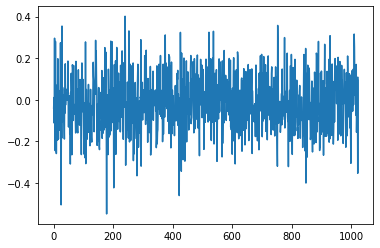

In [88]:
plt.plot(Z[idx1]- Z[idx2])

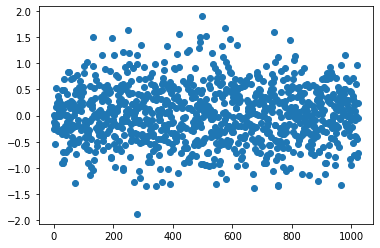

In [76]:
plt.plot(convolution,"o")

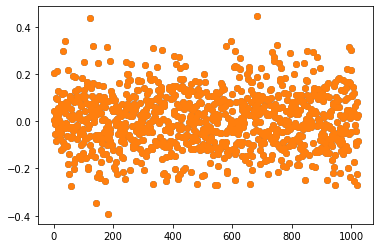

In [77]:
plt.plot(Z[idx1],"o")
plt.plot(Z[idx2],"o")

In [ ]:
Weights = torch.tensor([ 0.50267996, 93.78508198])